Registration of spatial transcriptomics data with Eggplant
==========================================================

This tutorial shows how to use **Eggplant** for registration of spatial transcriptomics data.

- [paper](https://www.biorxiv.org/content/10.1101/2021.11.11.468178v1.full)
- [code](https://github.com/almaan/eggplant)
- [tutorial](https://spatial-eggplant.readthedocs.io/en/latest/notebooks/mouse-olfactory-bulb-analysis.html)

You can read more on how the tool works [here](https://spatial-eggplant.readthedocs.io/en/latest/about.html).

Most of this code is taken from the original eggplant tutorial, but applied to new data.

In [1]:
import matplotlib.pyplot as plt
import scanpy as sc

import os
from PIL import Image
import pathlib
import anndata as ad
import pandas as pd
import numpy as np
import eggplant as eg
import squidpy as sq

sc.set_figure_params(figsize=(4, 4), frameon=False)

In [2]:
# set path
path = pathlib.Path("/home/icb/giovanni.palla/workspace/advomics_data_spatial")

Read reference image.

In [3]:
ref_img = Image.open(path / "dev-heart.png")
ref_lmk = pd.read_csv(path / "dev-heart_landmarks.tsv", sep="\t", header=0, index_col=0)

Inspect the reference image to make sure we loaded the correct image. Also plot the landmark coordinates to ensure that these match the reference.

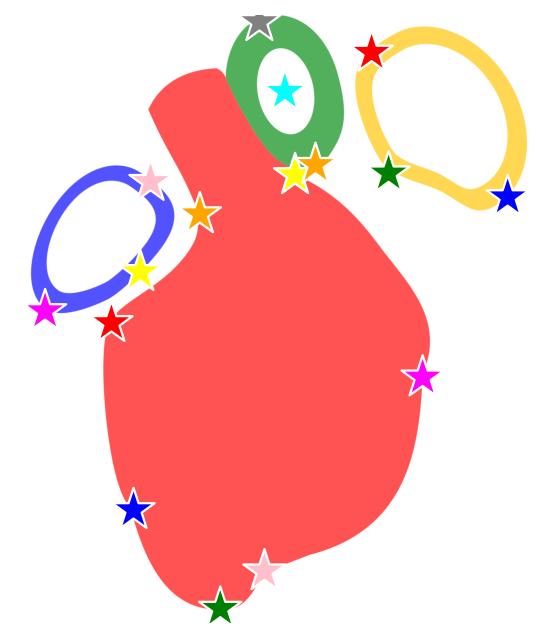

In [4]:
plt.figure(figsize=(5, 5))
lmk_cmap = eg.constants.LANDMARK_CMAP
cmap = eg.pl.ColorMapper(lmk_cmap)

plt.imshow(ref_img, alpha=0.7)
plt.scatter(
    ref_lmk.values[:, 0],
    ref_lmk.values[:, 1],
    marker="*",
    edgecolor="white",
    c=cmap(ref_lmk),
    s=400,
)
plt.axis("off")
plt.show()

We proceed to convert the image to a grid with associated meta data (which region each grid point belongs to). The number of points in the grid will be close to `n_approx_points`, the more points, the higher the resolution. The argument `n_regions` specifies how many regions we have defined, by different colors, in our reference.

In [5]:
grid_crd, mta = eg.pp.reference_to_grid(
    ref_img,
    n_approx_points=1000,
    n_regions=1,
)

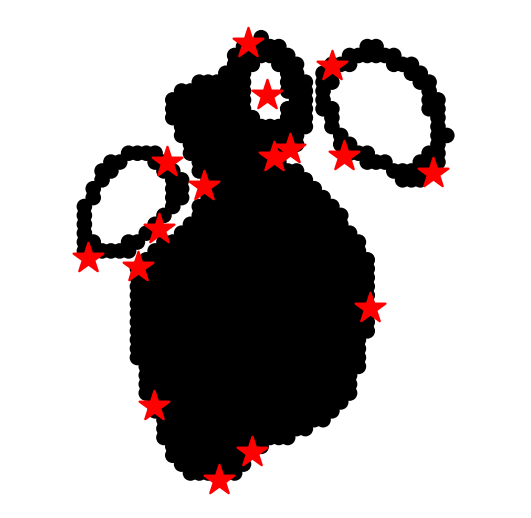

In [6]:
plt.scatter(
    grid_crd[:, 0],
    grid_crd[:, 1],
    c=mta,
    cmap=plt.cm.binary_r,
)

plt.scatter(
    ref_lmk.values[:, 0],
    ref_lmk.values[:, 1],
    marker="*",
    c="red",
    s=200,
)
plt.gca().invert_yaxis()
plt.axis("equal")
plt.axis("off")
plt.show()

We now create a reference object that we'll use later. We'll also execute some standard pre-processing.

In [7]:
ref = eg.m.Reference(
    grid_crd,
    landmarks=ref_lmk.values,
    meta=dict(region=mta),
)

In [8]:
files = ["V10F24-105_A1.h5ad", "V10S28-371_A1.h5ad", "V10F24-105_C1.h5ad"]
adatas = {}
for f in files:
    adata = sc.read(path / f)
    adata.var_names_make_unique()
    adata.obs_names_make_unique()
    adata = adata[:,adata.var.highly_variable].copy()
    adata.X = adata.layers["counts"].copy()
    adatas[f.strip(".h5ad")] = adata

We select 4 genes for later.

In [9]:
genes = ["ELN", "MYH6", "A2M", "NPPA"]

In [10]:
for adata in adatas.values():
    eg.pp.default_normalization(
        adata, min_cells=0.1, total_counts=1e4, exclude_highly_expressed=False
    )

    eg.pp.match_scales(adata, ref)
    eg.pp.get_landmark_distance(adata, reference=ref)

    eg.pp.spatial_smoothing(adata)

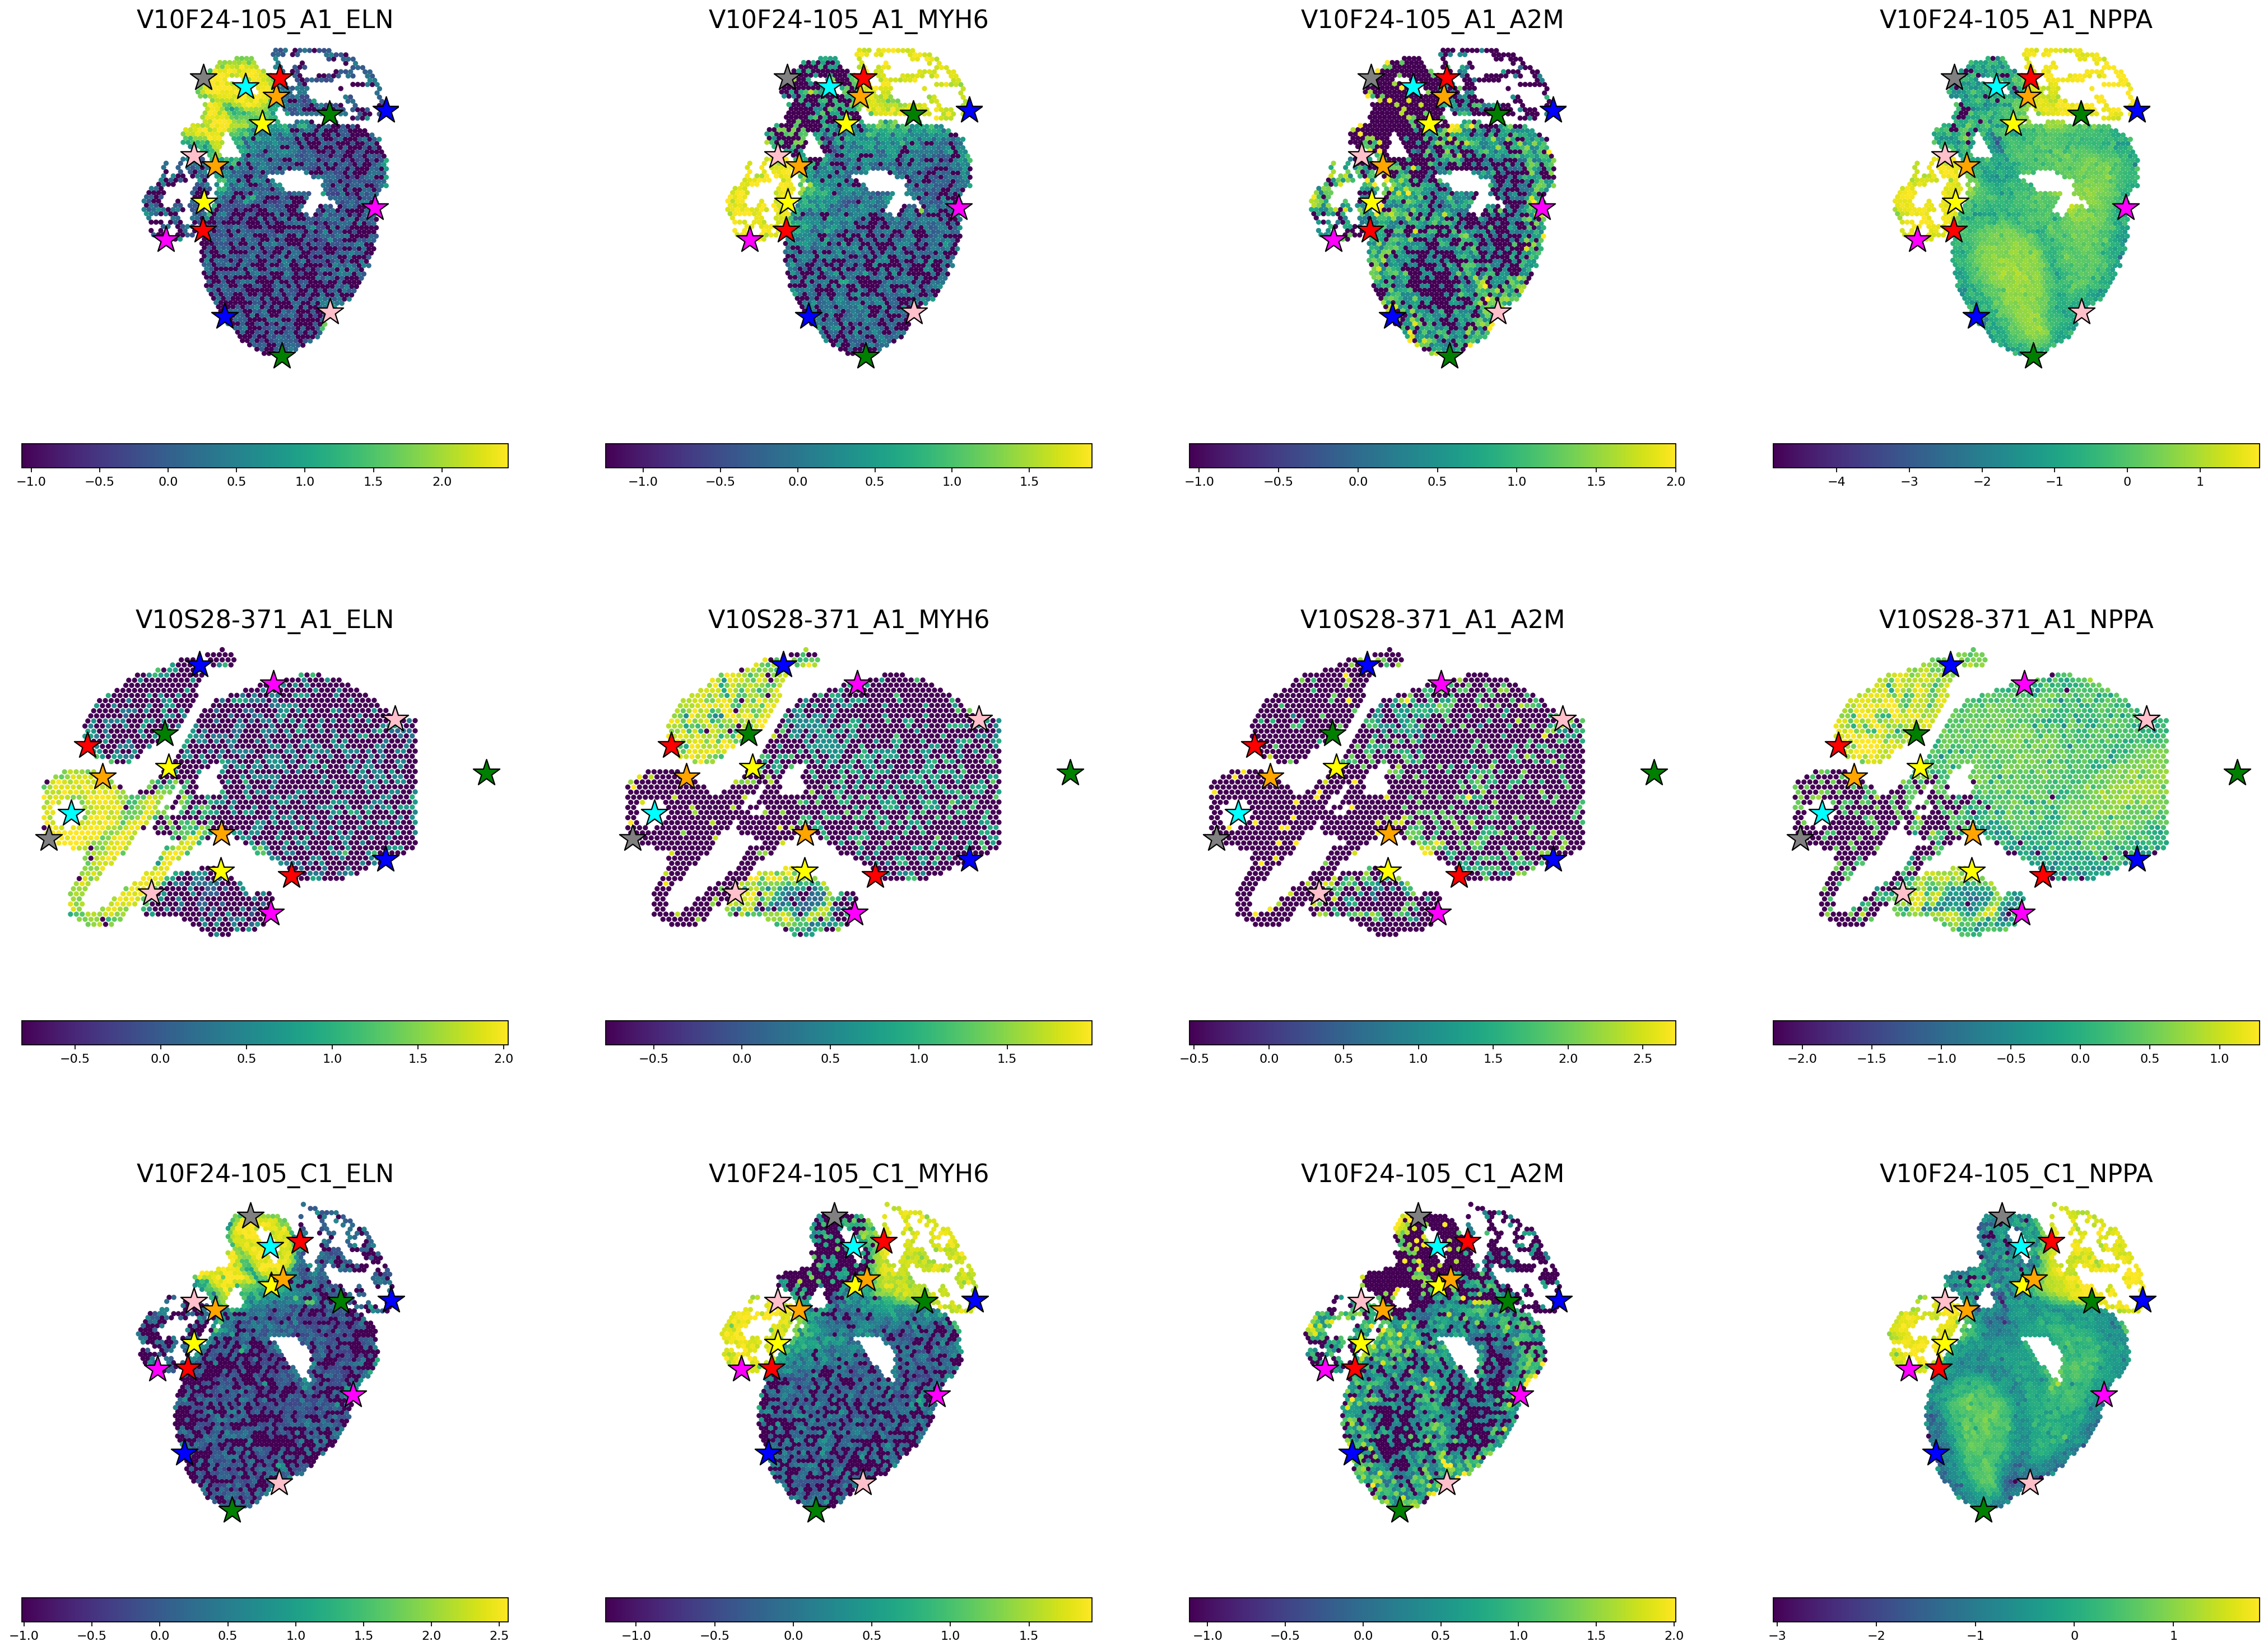

In [11]:
eg.pl.visualize_observed(
    adatas,
    features=genes,
    n_cols=4,
    include_title=True,
    fontsize=20,
    marker_size=10,
    share_colorscale=False,
    separate_colorbar=False,
    colorbar_fontsize=10,
    side_size=8,
    show_landmarks=True,
    quantile_scaling=True,
    flip_y=True
)

### Model
Eggplant is based on Gaussian process regression. Gaussian Processed are defined as :

$y \sim GP(\mu(.), K(.))$

here, $K(X)$ where $X_{i,j}$ is a distance matrix between query points $i$ and landmark points $j$. Regression is standard gaussian likelihood. After model fitting, inferred gene expression values are inferred for the "reference" data points.

In [12]:
losses = eg.fun.transfer_to_reference(
    adatas,
    reference=ref,
    layer="smoothed",
    features=genes,
    n_epochs=400,
    device="gpu", # set 'cpu' if gpu is unavailable
    verbose=True,
)

[Processing] ::  Model : V10F24-105_A1 | Feature : ELN | Transfer : 1/12


100%|██████████| 400/400 [00:17<00:00, 23.16it/s]


[Processing] ::  Model : V10F24-105_A1 | Feature : MYH6 | Transfer : 2/12


/home/icb/giovanni.palla/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████| 400/400 [00:10<00:00, 38.68it/s]


[Processing] ::  Model : V10F24-105_A1 | Feature : A2M | Transfer : 3/12


100%|██████████| 400/400 [00:11<00:00, 34.11it/s]


[Processing] ::  Model : V10F24-105_A1 | Feature : NPPA | Transfer : 4/12


100%|██████████| 400/400 [00:11<00:00, 34.46it/s]


[Processing] ::  Model : V10S28-371_A1 | Feature : ELN | Transfer : 5/12


/home/icb/giovanni.palla/miniconda3/envs/scvi/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
100%|██████████| 400/400 [00:11<00:00, 34.27it/s]


[Processing] ::  Model : V10S28-371_A1 | Feature : MYH6 | Transfer : 6/12


100%|██████████| 400/400 [00:11<00:00, 34.19it/s]


[Processing] ::  Model : V10S28-371_A1 | Feature : A2M | Transfer : 7/12


100%|██████████| 400/400 [00:11<00:00, 33.66it/s]


[Processing] ::  Model : V10S28-371_A1 | Feature : NPPA | Transfer : 8/12


100%|██████████| 400/400 [00:11<00:00, 34.34it/s]


[Processing] ::  Model : V10F24-105_C1 | Feature : ELN | Transfer : 9/12


100%|██████████| 400/400 [00:11<00:00, 34.33it/s]


[Processing] ::  Model : V10F24-105_C1 | Feature : MYH6 | Transfer : 10/12


100%|██████████| 400/400 [00:11<00:00, 34.49it/s]


[Processing] ::  Model : V10F24-105_C1 | Feature : A2M | Transfer : 11/12


100%|██████████| 400/400 [00:11<00:00, 34.44it/s]


[Processing] ::  Model : V10F24-105_C1 | Feature : NPPA | Transfer : 12/12


100%|██████████| 400/400 [00:11<00:00, 33.89it/s]


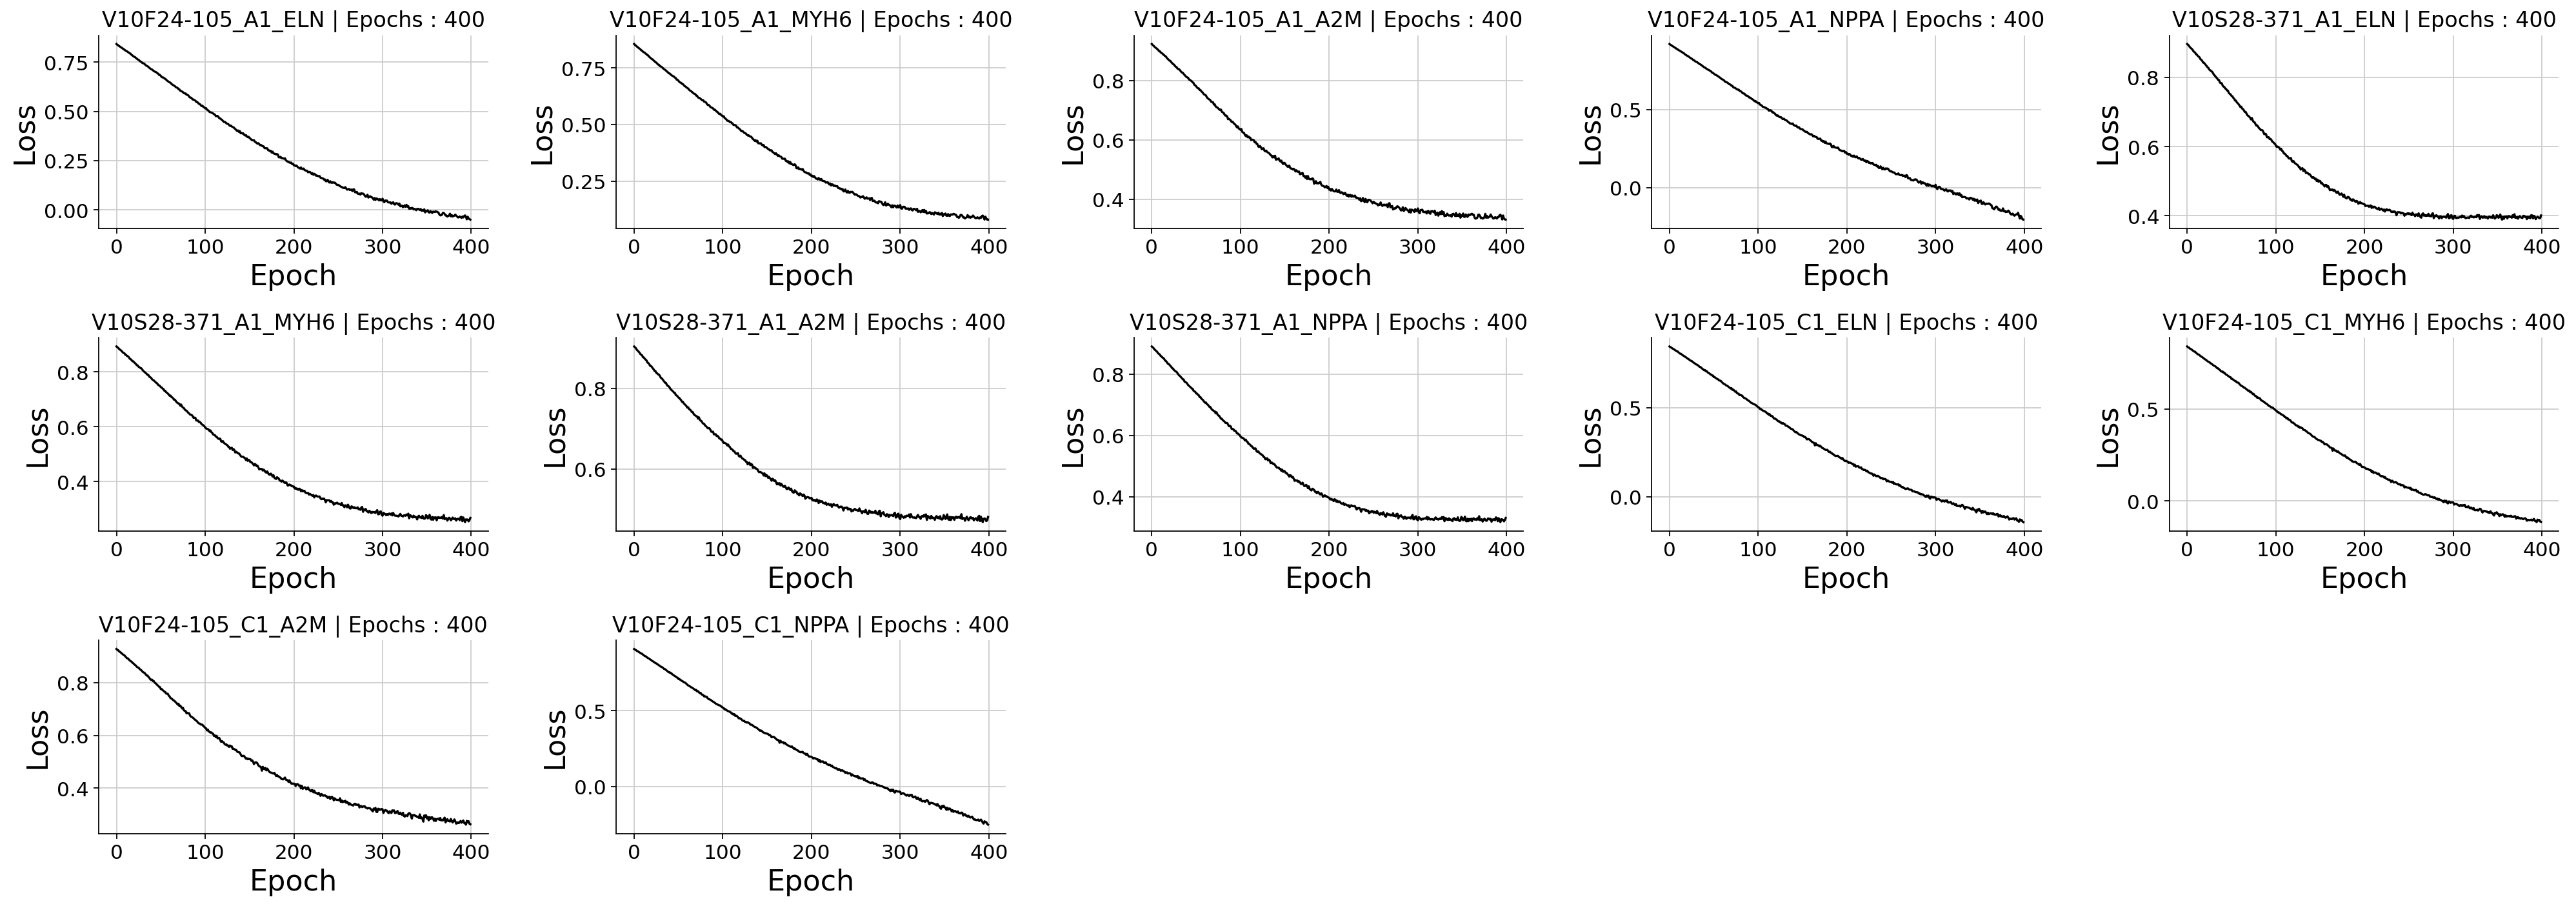

In [13]:
eg.pl.model_diagnostics(
    losses=losses,
)

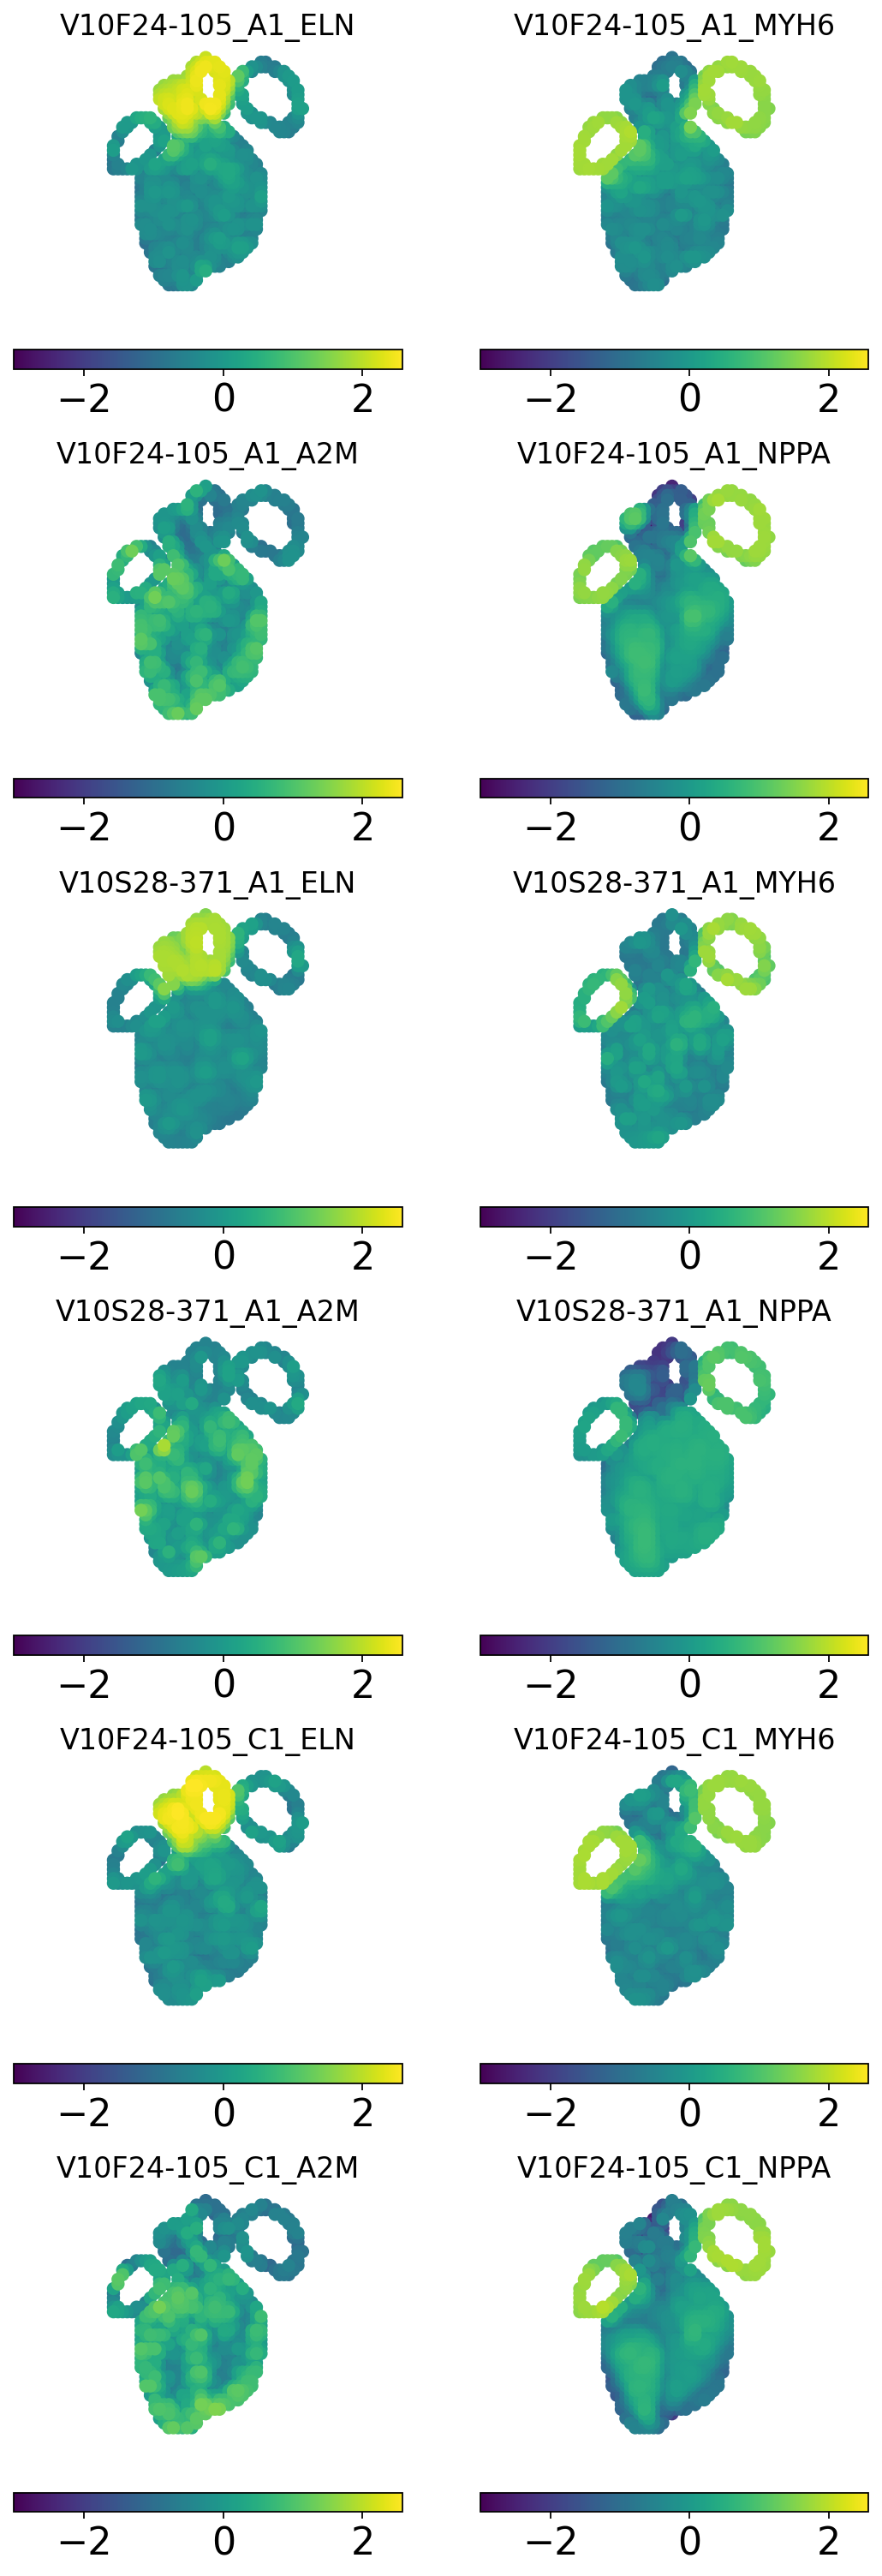

In [14]:
eg.pl.visualize_transfer(
    ref,
    n_cols=2,
    attributes=genes,
    include_title=True,
    fontsize=15,
    marker_size=35,
    share_colorscale=True,
    separate_colorbar=False,
    colorbar_fontsize=20,
    side_size=4,
    show_landmarks=False,
    flip_y=True,
    quantile_scaling=False,
)

In [15]:
ref.adata.var

model feature
V10F24-105_A1_ELN   V10F24-105_A1     ELN
V10F24-105_A1_MYH6  V10F24-105_A1    MYH6
V10F24-105_A1_A2M   V10F24-105_A1     A2M
V10F24-105_A1_NPPA  V10F24-105_A1    NPPA
V10S28-371_A1_ELN   V10S28-371_A1     ELN
V10S28-371_A1_MYH6  V10S28-371_A1    MYH6
V10S28-371_A1_A2M   V10S28-371_A1     A2M
V10S28-371_A1_NPPA  V10S28-371_A1    NPPA
V10F24-105_C1_ELN   V10F24-105_C1     ELN
V10F24-105_C1_MYH6  V10F24-105_C1    MYH6
V10F24-105_C1_A2M   V10F24-105_C1     A2M
V10F24-105_C1_NPPA  V10F24-105_C1    NPPA

We can then move on and perform spatial differential expression analysis. Read more about it in the [paper](https://www.biorxiv.org/content/10.1101/2021.11.11.468178v1.full).

In [16]:
res = eg.sdea.sdea(
    ref.adata,
    group_col="feature",
    n_std=2,
)

In [30]:
len(res)

6

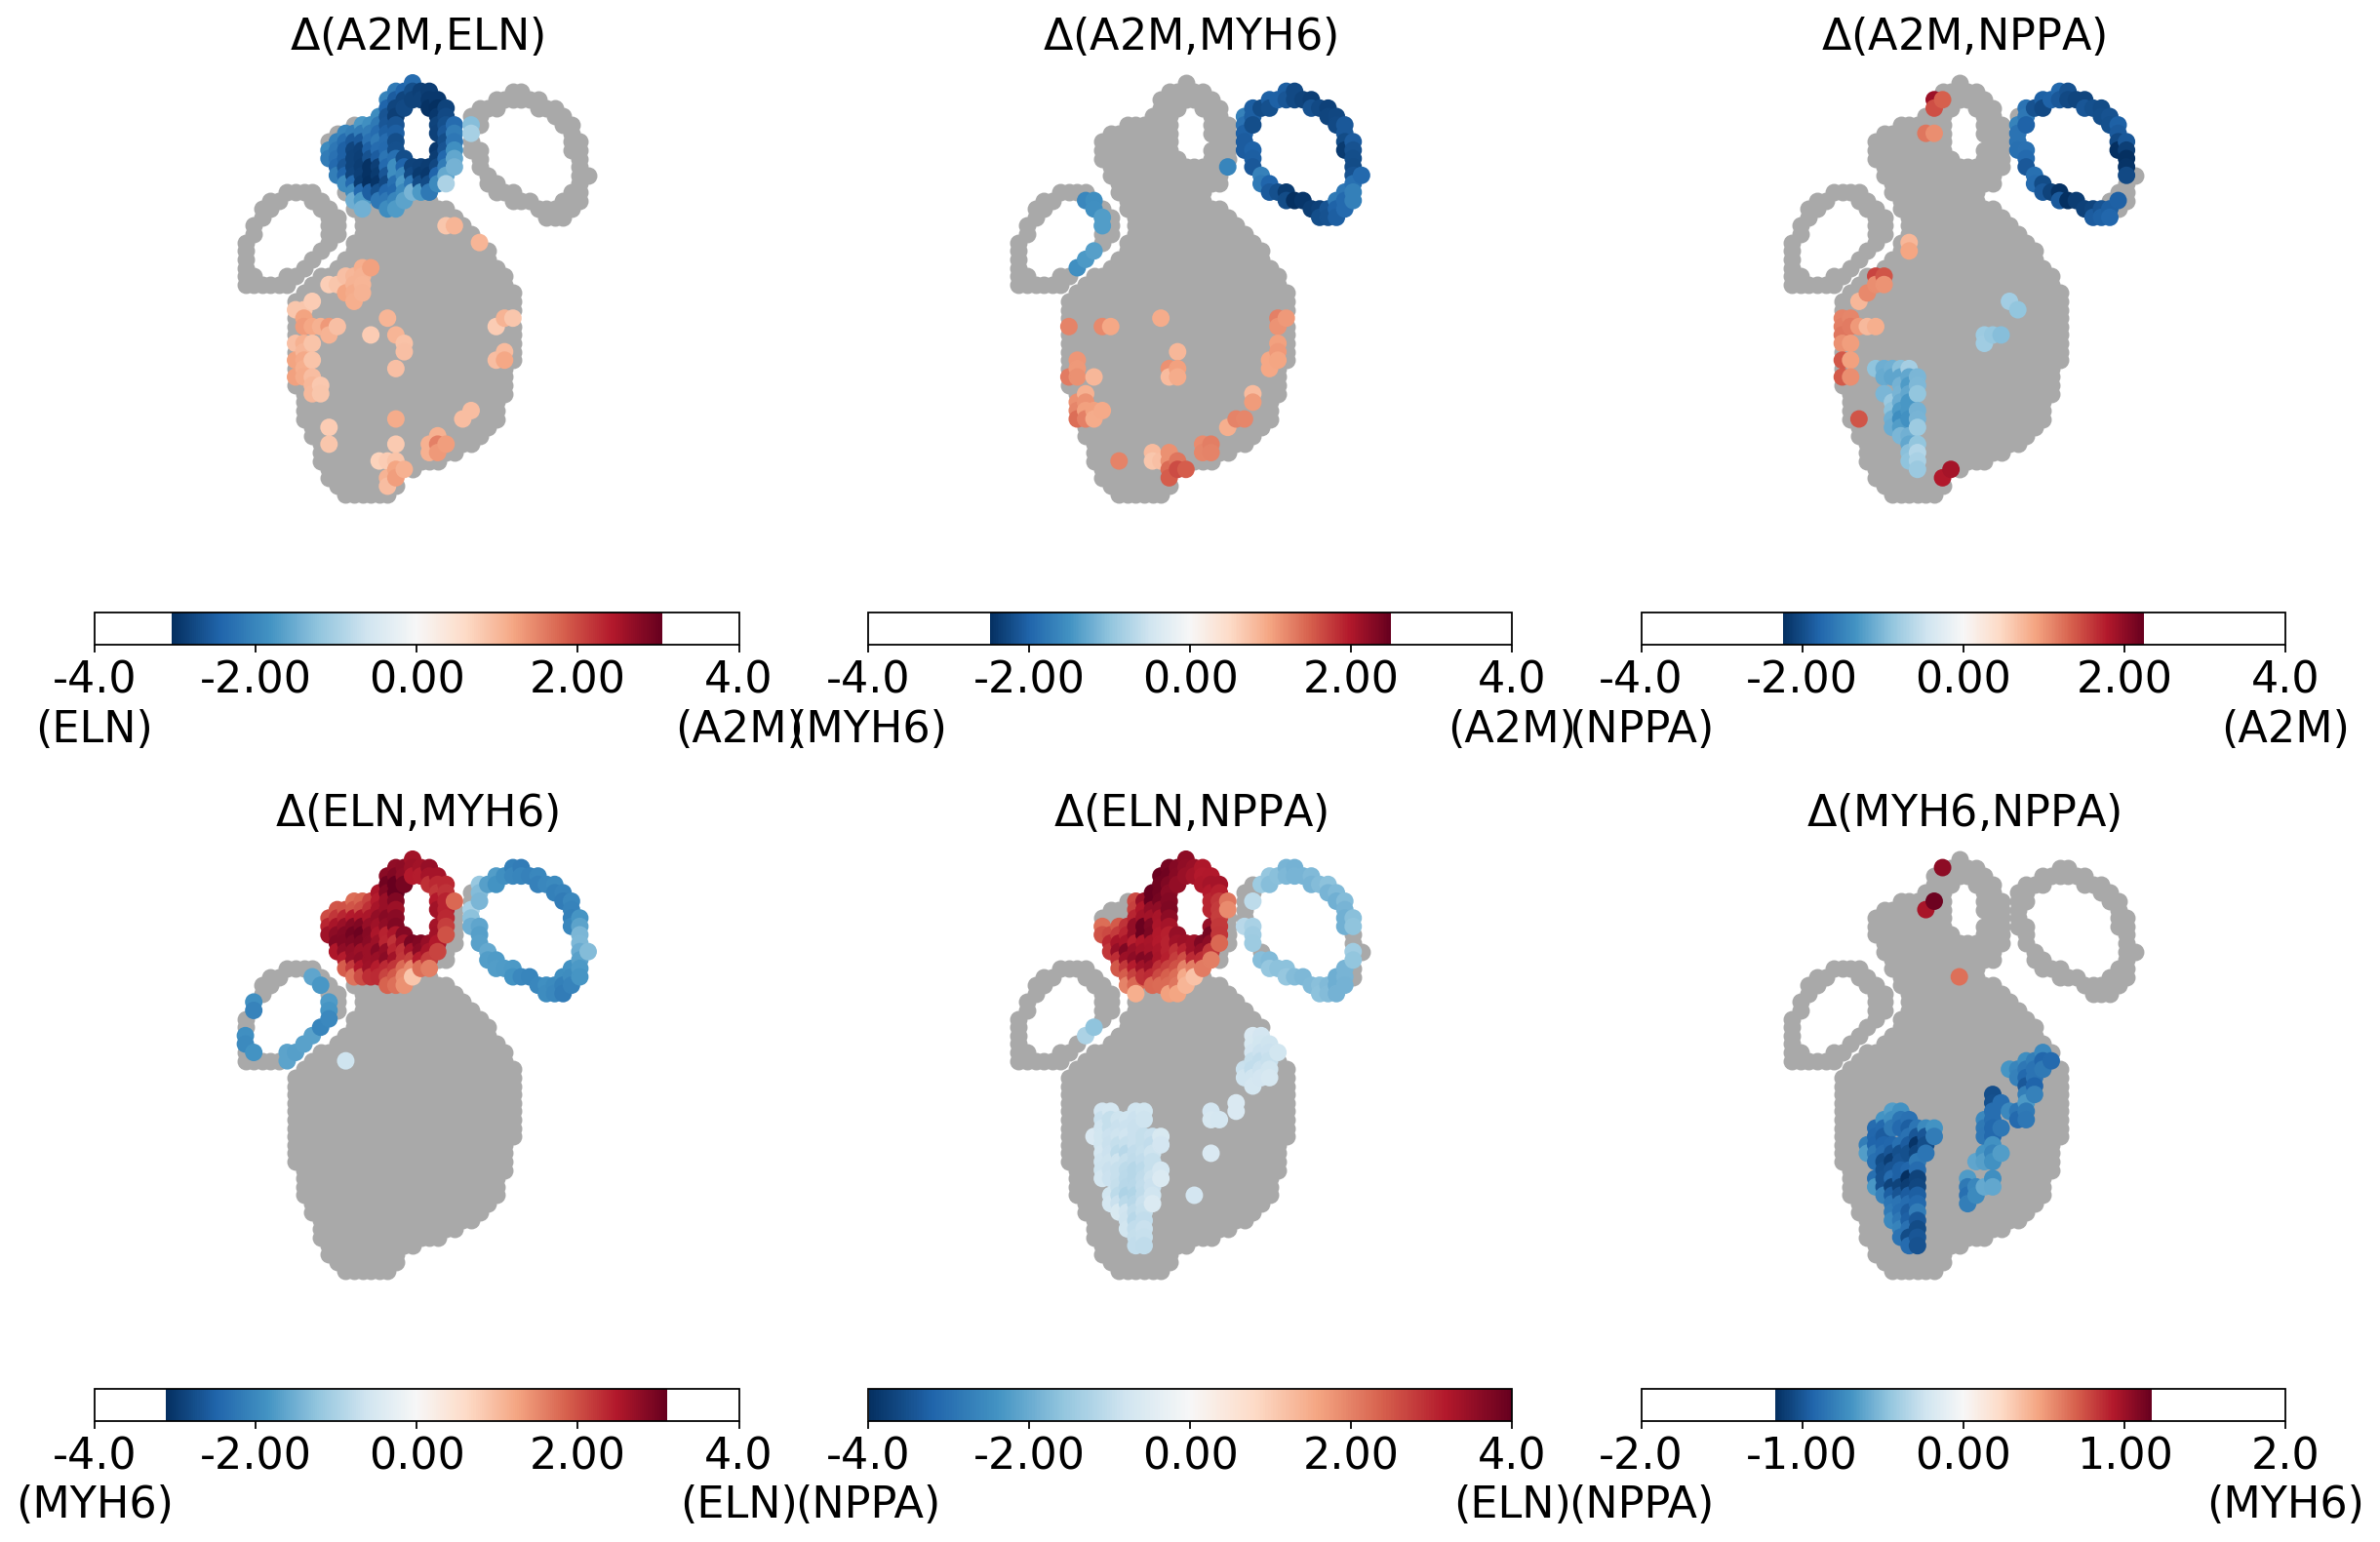

In [33]:
eg.pl.visualize_sdea_results(
    ref,
    res,
    n_cols=3,
    marker_size=50,
    side_size=6,
    colorbar_orientation="horizontal",
    title_fontsize=20,
    colorbar_fontsize=20,
    no_sig_color="darkgray",
    reorder_axes=np.arange(6),
)

Finally, we can generate *composite representations*, which computies the location-wise mean across all 3 sections.

In [34]:
ref.composite_representation(by="feature")

/home/icb/giovanni.palla/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/utils.py:143: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/home/icb/giovanni.palla/miniconda3/envs/scvi/lib/python3.9/site-packages/eggplant/models.py:453: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.adata = ad.AnnData(
/home/icb/giovanni.palla/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/giovanni.palla/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/utils.py:143: UserWarning: Layer 'var' converted to numpy array with dtype floa

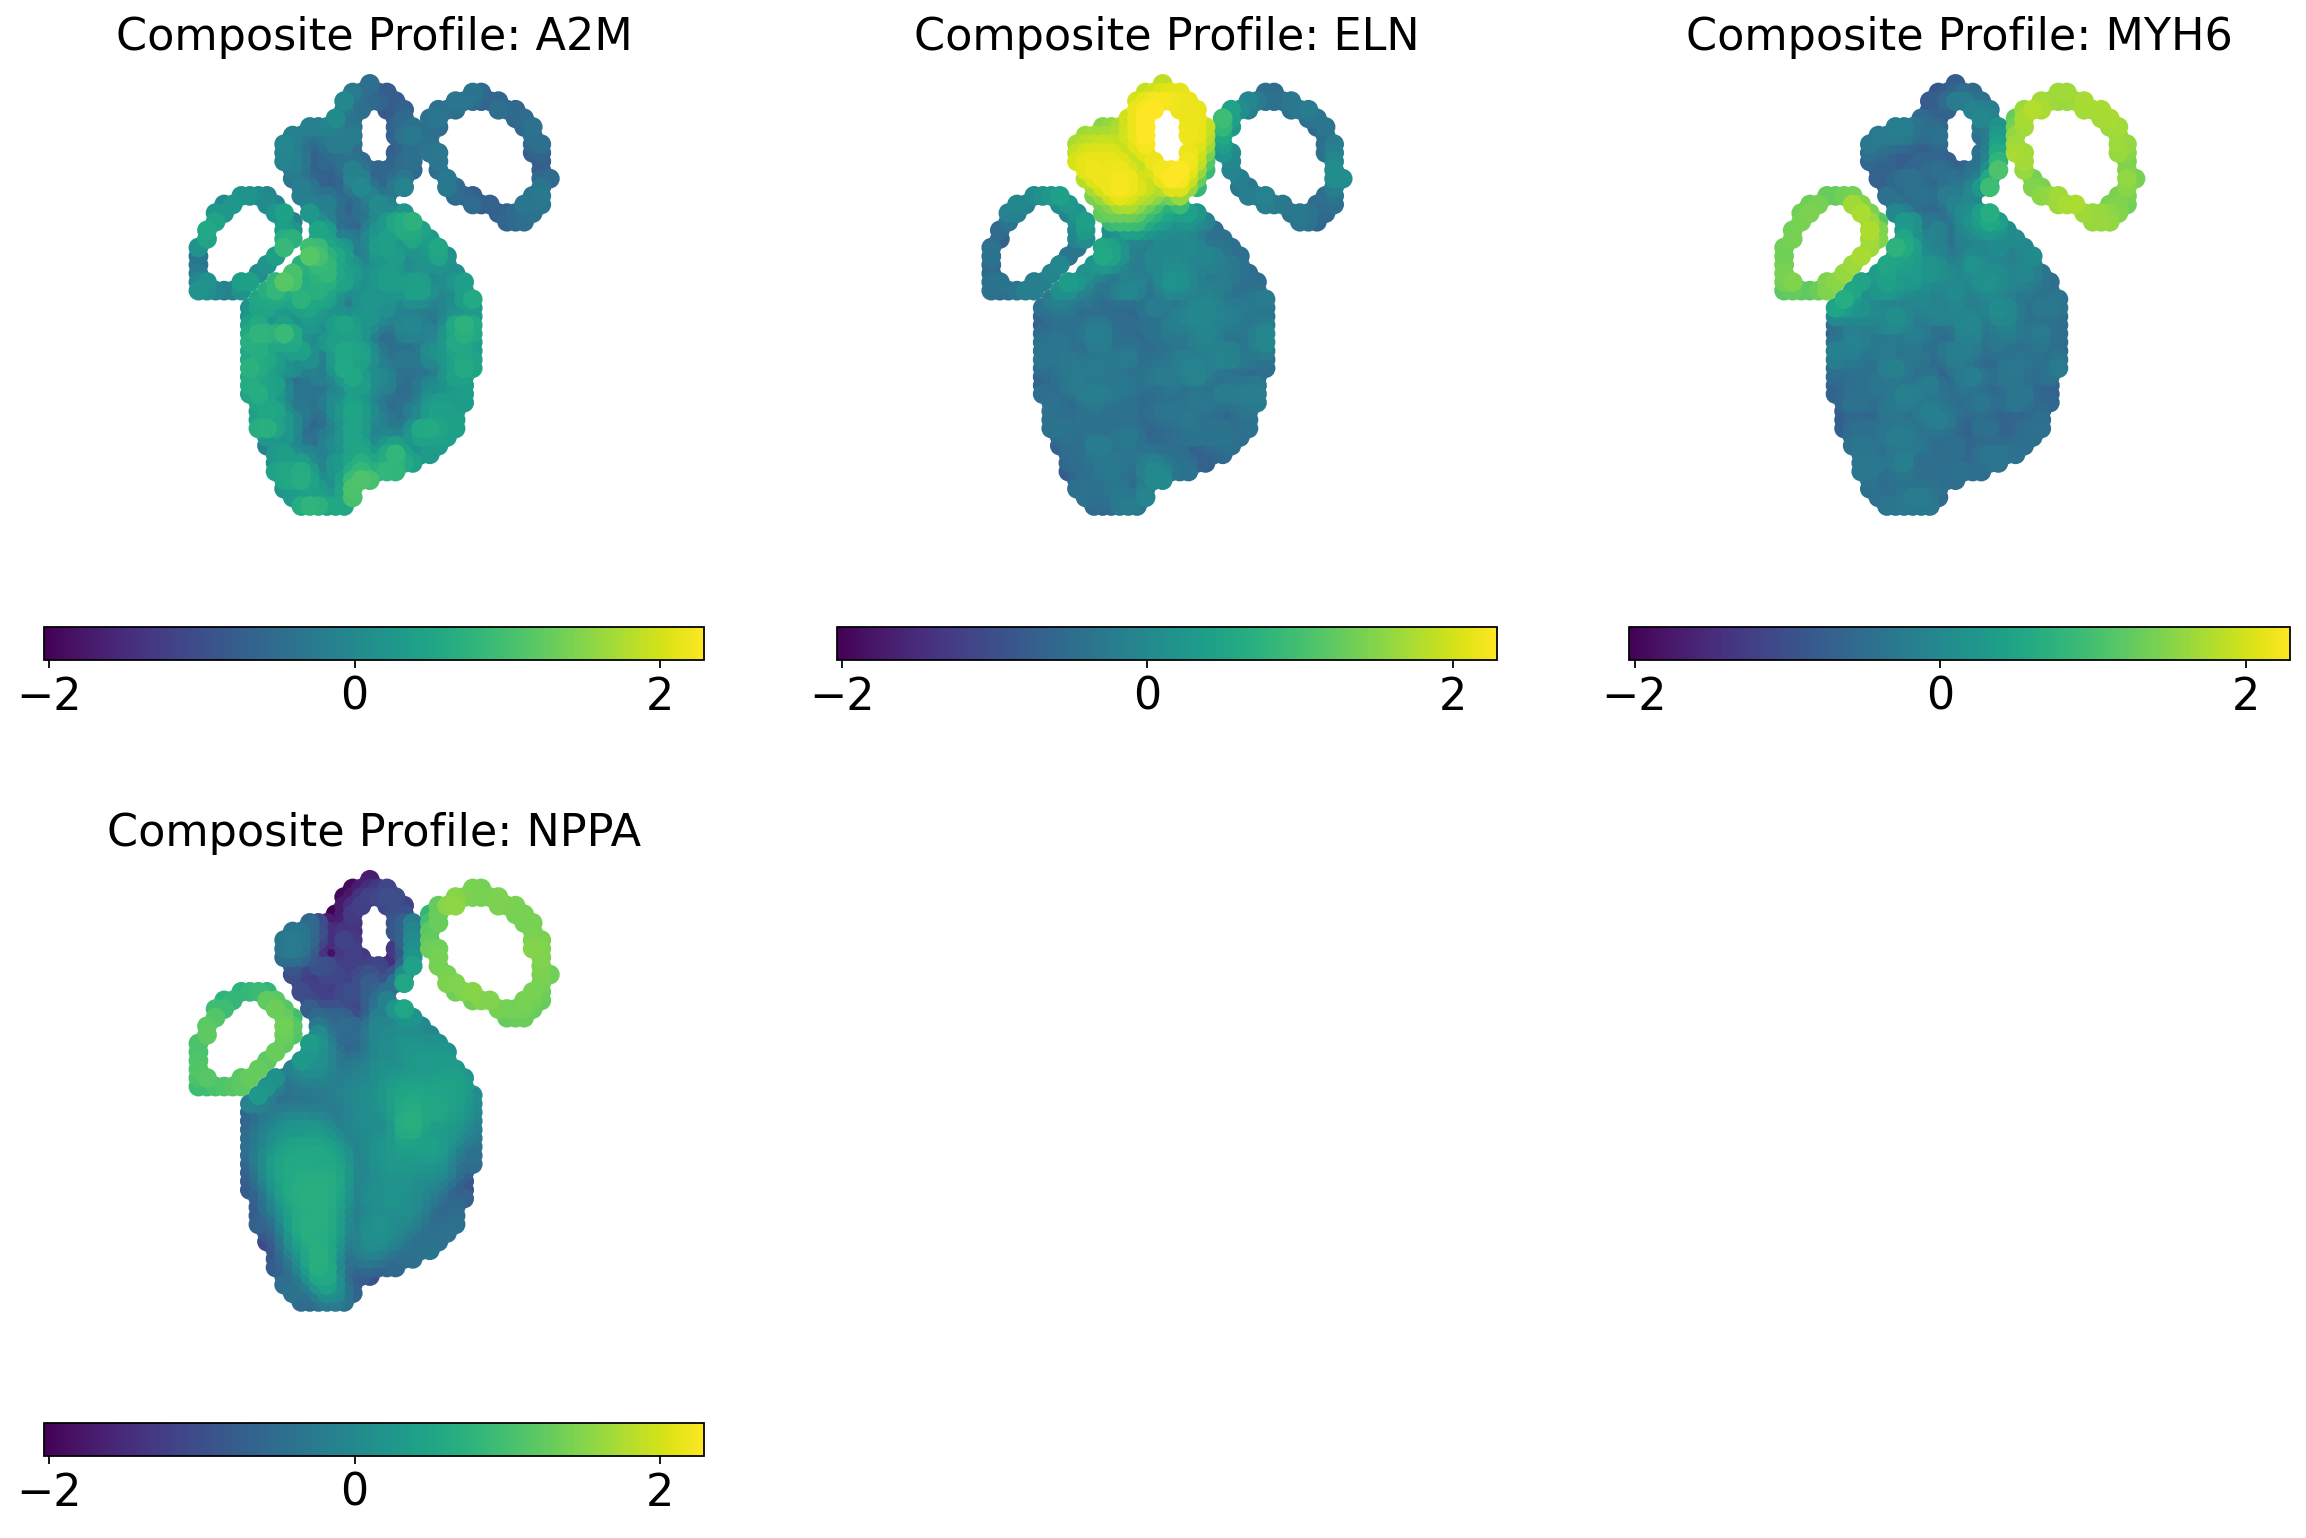

In [35]:
eg.pl.visualize_transfer(
    ref,
    attributes="composite",
    n_cols=3,
    include_title=True,
    fontsize=20,
    colorbar_fontsize=20,
    marker_size=62,
    share_colorscale=True,
    separate_colorbar=False,
    side_size=6,
    show_landmarks=False,
    flip_y=True,
    quantile_scaling=False,
)

In [36]:
ref.adata.var

model feature
V10F24-105_A1_ELN   V10F24-105_A1     ELN
V10F24-105_A1_MYH6  V10F24-105_A1    MYH6
V10F24-105_A1_A2M   V10F24-105_A1     A2M
V10F24-105_A1_NPPA  V10F24-105_A1    NPPA
V10S28-371_A1_ELN   V10S28-371_A1     ELN
V10S28-371_A1_MYH6  V10S28-371_A1    MYH6
V10S28-371_A1_A2M   V10S28-371_A1     A2M
V10S28-371_A1_NPPA  V10S28-371_A1    NPPA
V10F24-105_C1_ELN   V10F24-105_C1     ELN
V10F24-105_C1_MYH6  V10F24-105_C1    MYH6
V10F24-105_C1_A2M   V10F24-105_C1     A2M
V10F24-105_C1_NPPA  V10F24-105_C1    NPPA
composite_A2M           composite     A2M
composite_ELN           composite     ELN
composite_MYH6          composite    MYH6
composite_NPPA          composite    NPPA

Remember, the reference object is an *anndata* so you could use it for downstream analysis.

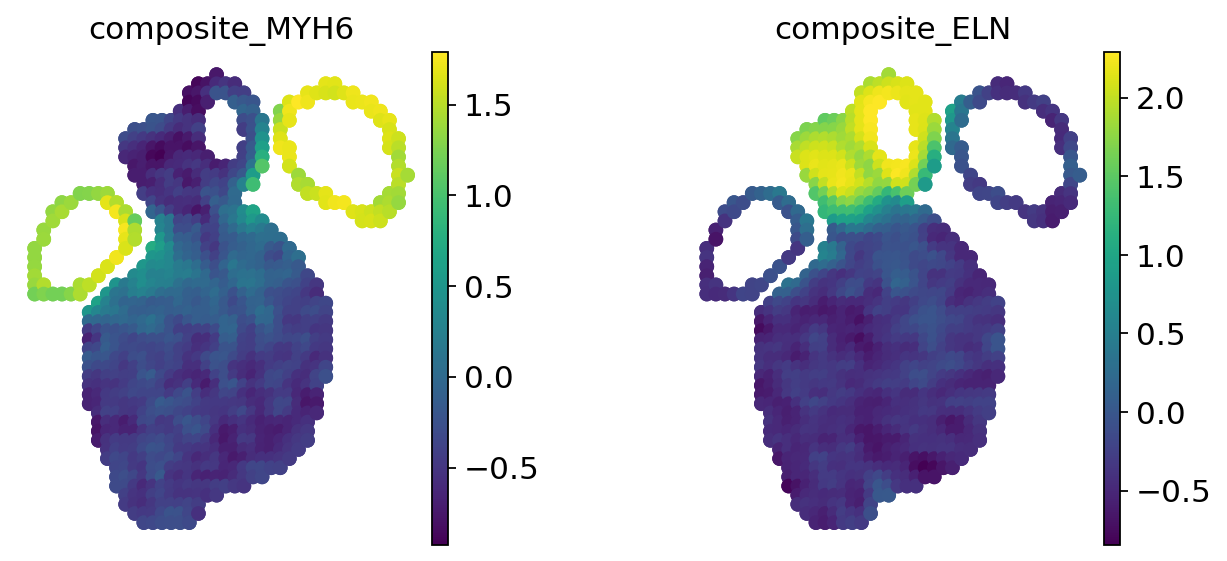

In [37]:
sq.pl.spatial_scatter(ref.adata, shape=None, color=["composite_MYH6", "composite_ELN"])

### Exercise

#### Common Coordinate Framework with cell-type proportions
You can perform the same type of "registration analysis" by cell-types. Remember how to create an anndata from cell-type proportions (previous tutorial).

```python
adata_prop = ad.AnnData(
    st_adata.obsm["deconvolution"].copy(),
    obsm=st_adata.obsm.copy(),
    obs=st_adata.obs.copy(),
    uns=st_adata.uns.copy(),
)
adata_prop.var_names = st_adata.obsm["deconvolution"].columns
```


